In [ ]:
import os
import re
import shutil
import string
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras import losses

Download dataset:

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [ ]:
dataset

'./aclImdb_v1'

Explore directories:

In [ ]:
os.listdir(dataset_dir)

['imdbEr.txt', 'imdb.vocab', 'README', 'train', 'test']

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['pos',
 'urls_unsup.txt',
 'unsupBow.feat',
 'urls_pos.txt',
 'urls_neg.txt',
 'labeledBow.feat',
 'unsup',
 'neg']

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())


Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


Load data from directories using text_dataset_from_directory
---



In [ ]:
# remove the "unsup" folder to respect the folder structure
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [ ]:
# Create validation and training sets from the training folder
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
# create test dataset
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


In [ ]:
raw_train_ds.class_names

['neg', 'pos']

In [ ]:
raw_train_ds

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
# show one batch of reviews
for i in raw_train_ds.take(1):
  print(i[0])

tf.Tensor(
[b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
 b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into complicat

In [ ]:
# show one batch of corresponding labels
for i in raw_train_ds.take(1):
  print(i[1])

tf.Tensor([1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 1 1 1 0 0], shape=(32,), dtype=int32)


In [ ]:
for text, label in raw_test_ds.take(1):
  for i in range(1):
    print(text[i])
    print(label[i])

tf.Tensor(b"This obviously was a pretty low budget production, but the cast was pretty decent, the basic premise had promise, and something more could have been done with it, but the script wasn't that great- the plot is incoherent and seems almost random at times and the dialog is stilted and terrible.<br /><br />Basically, a girl's father gets whacked by fellow gangsters, and later she becomes a robber, and wants to avenge his death, and then it goes into a mob protection racket involving corrupt politicians.<br /><br />Alan Ladd gets top billing but he really plays a very minor role.<br /><br />I have to say I found it mildly entertaining in its archaic B-grade hokiness but it really is shoddy and pathetic.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)


Text pre-processing
---



In [ ]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Create the pre-processing layer:

In [ ]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Fit the pre-processing layer (vectorize_layer) to the training data


In [ ]:
# remove labels
train_text = raw_train_ds.map(lambda x, y: x)

# fit the layer using the adapt method
vectorize_layer.adapt(train_text)

See result of the pre-processing layer:

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [ ]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))

first_review, first_label = text_batch[0], label_batch[0]

print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])

print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Belmondo is a tough cop. He goes after a big-time drug dealer (played by Henry Silva, normally a great villain - see "Sharky\'s Machine"; but here he is clearly dubbed, and because of that he lacks his usual charisma). He goes to the scuzziest places of Paris and Marseilles, asks for some names, beats up some people, gets the names, goes to more scuzzy places, asks for more names, beats up more people, etc. The whole movie is punch after punch after punch. It seems that the people who made it had no other ambition than to create the French equivalent of "Dirty Harry". Belmondo, who was 50 here, does perform some good stunts at the beginning; apart from those, "Le Marginal" is a violent, episodic, trite, shallow and forgettable cop movie. (*1/2)', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   1,    7,    4, 1233, 1021,   27,  261,  101,    4,    1, 1525,
        6992,  248,   32, 1488,    1, 1659,    4,

In [ ]:
print("48 ---> ",vectorize_layer.get_vocabulary()[48])

print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

48 --->  what
Vocabulary size: 10000


In [ ]:
vectorize_layer.get_vocabulary()[:10]

['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it']

Apply the pre-processing layer all the sets:

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Pipeline optimization:

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Create the model
---



In [ ]:
embedding_dim = 16

model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
________________________________________________

Define loss function and optimizer:

In [ ]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

Train the model:

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 11s 16ms/step - loss: 0.6641 - binary_accuracy: 0.6918 - val_loss: 0.6147 - val_binary_accuracy: 0.7758
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.5484 - binary_accuracy: 0.8017 - val_loss: 0.4977 - val_binary_accuracy: 0.8212
Epoch 3/10
625/625 [==============================] - 5s 9ms/step - loss: 0.4441 - binary_accuracy: 0.8443 - val_loss: 0.4198 - val_binary_accuracy: 0.8464
Epoch 4/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3779 - binary_accuracy: 0.8656 - val_loss: 0.3734 - val_binary_accuracy: 0.8590
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3358 - binary_accuracy: 0.8791 - val_loss: 0.3448 - val_binary_accuracy: 0.8674
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3052 - binary_accuracy: 0.8881 - val_loss: 0.3261 - val_binary_accuracy: 0.8720
Epoch 7/10
625/625 [==============================] - 5s 8ms/s

Visulalize training performance:

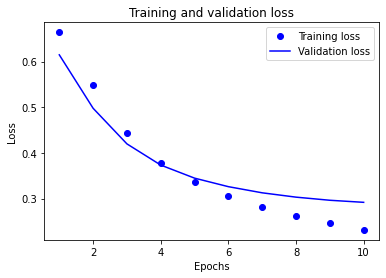

In [ ]:
history_dict = history.history

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Evaluate the model on test data:

In [ ]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 11ms/step - loss: 0.3097 - binary_accuracy: 0.8738
Loss:  0.3097192049026489
Accuracy:  0.8737599849700928


Inference on new data
---



Export model:

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 10s 12ms/step - loss: 0.3097 - accuracy: 0.8738
0.8737599849700928


Inference on new data:

In [ ]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - 0s 161ms/step


array([[0.65236694],
       [0.47977355],
       [0.39432266]], dtype=float32)